In [1]:
from itertools import combinations
import numpy as np
from z3 import *
import utils

In [2]:
WIDTH = 0
HEIGHT = 1

In [3]:
def at_least_one_np(bool_vars):
    return Or(bool_vars)

def at_most_one_np(bool_vars, name = ""):
    return [Not(And(pair[0], pair[1])) for pair in combinations(bool_vars, 2)]

def exactly_one_np(bool_vars, name = ""):
    return And(at_least_one_np(bool_vars), And(at_most_one_np(bool_vars, name)))

In [4]:
def at_least_one_seq(bool_vars):
    return at_least_one_np(bool_vars)

def at_most_one_seq(bool_vars, name):
    constraints = []
    n = len(bool_vars)
    s = [Bool(f"s_{name}_{i}") for i in range(n - 1)] # Need the s to have unique names
    constraints.append(Or(Not(bool_vars[0]), s[0]))
    constraints.append(Or(Not(bool_vars[n-1]), Not(s[n-2])))

    for i in range(1, n-1):
        constraints.append(Or(Not(bool_vars[i]), s[i]))
        constraints.append(Or(Not(s[i - 1]), s[i]))
        constraints.append(Or(Not(bool_vars[i]), Not(s[i - 1])))
    
    return And(constraints)

def exactly_one_seq(bool_vars, name):
    return And(at_most_one_seq(bool_vars, name), at_least_one_seq(bool_vars))

In [5]:
def at_least_k_seq(bool_vars, k, name):
    return at_most_k_seq([Not(var) for var in bool_vars], len(bool_vars)-k, name)

def at_most_k_seq(bool_vars, k, name):
    constraints = []
    n = len(bool_vars)
    s = [[Bool(f"s_{name}_{i}_{j}") for j in range(k)] for i in range(n - 1)]
    constraints.append(Or(Not(bool_vars[0]), s[0][0]))
    constraints += [Not(s[0][j]) for j in range(1, k)]
    for i in range(1, n-1):
        constraints.append(Or(Not(bool_vars[i]), s[i][0]))
        constraints.append(Or(Not(s[i-1][0]), s[i][0]))
        constraints.append(Or(Not(bool_vars[i]), Not(s[i-1][k-1])))
        for j in range(1, k):
            constraints.append(Or(Not(bool_vars[i]), Not(s[i-1][j-1]), s[i][j]))
            constraints.append(Or(Not(s[i-1][j]), s[i][j]))
    constraints.append(Or(Not(bool_vars[n-1]), Not(s[n-2][k-1])))   
    return And(constraints)

def exactly_k_seq(bool_vars, k, name):
    # The s list in at_most_k_seq must have unique names, so when we use it in at_least_k_seq it 
    # has to have a diffrent name from when we use it in at_most_k_seq. Hence name+"2"
    return And(at_most_k_seq(bool_vars, k, name), at_least_k_seq(bool_vars, k, name+"2"))

In [50]:
def coherent_cicuits(bool_vars, dims, n, w, upper_bound):
    constraints = []
    for c in range(n):
        c_constraints = []
        height = dims[c][1]
        width = dims[c][0]
        for x in range(w-(dims[c][0]-1)):
            for y in range(upper_bound-(dims[c][1]-1)):
                temp = [bool_vars[x+i][y+j][c] for i in range(0, width) for j in range(0, height)]
                # temp2 = And([Not(bool_vars[x+i][y+j][c]) for i in range(0, width) for j in range(0, height) if bool_vars[x+i][y+j][c] not in temp])
                # cons = Or(Not(bool_vars[x][y][c]), And(temp))
                # c_constraints.append(And(And(temp), temp2))
                c_constraints.append(And(temp))
        # constraints.append(Or(c_constraints))  
        ex = exactly_one_seq(c_constraints, f"Hello_{c}")
        constraints.append(ex)
              
    return And(constraints)



In [51]:
def vlsi_design(w, n, dims, upper_bound):
    s = Solver()
    # upper_bound = sum(dims[:, 1])
    print("Upper bound:", upper_bound)

    # Model the problem
    v = [[[Bool(f"v_{x}_{y}_{c}") for c in range(n)] for y in range(upper_bound)] for x in range(w)]
    
    # At most one circuit in each grid cell
    for x in range(w):
        for y in range(upper_bound):
            predicate = v[x][y]
            # print(predicate)
            s.add(at_most_one_seq(predicate, f"valid_cell_{x}_{y}"))
    
    # All the circuits must be placed in the grid
    """for c in range(n):
        circuit_area = dims[c, WIDTH] * dims[c, HEIGHT]
        predicate = [v[x][y][c] for x in range(w) for y in range(upper_bound)]
        s.add(exactly_k_seq(predicate, circuit_area, f"valid_placement_{c}"))"""
    
    s.add(coherent_cicuits(v, dims, n, w, upper_bound))
    
    return s, v


    """if s.check() == sat:
        model = s.model()
        sol = []
        for x in range(w):
            sol.append([])
            for y in range(upper_bound):
                found_circuit = False
                for c in range(n):
                    if model.evaluate(v[x][y][c]):
                        found_circuit = True
                        sol[x].append(c+1)
                if not found_circuit:
                    sol[x].append(0)

        return sol
    else:
        print("Buhu")"""

Upper bound: 6
Trying again with l= 7
Upper bound: 7
Trying again with l= 8
Upper bound: 8
Trying again with l= 9
Upper bound: 9
Trying again with l= 10
Upper bound: 10
Trying again with l= 11
Upper bound: 11


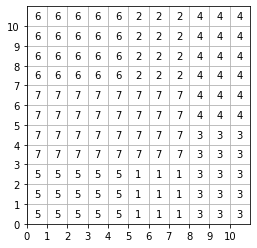

In [52]:
#w = 8
#n = 4
#dims = np.array([[3, 3], [3, 5], [5, 3], [5, 5]])

w = 11
n = 7
dims = np.array([[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]])

upperbound = sum(dims[:, 1])
l = max(dims[:,1])
# l = 12
s, v = vlsi_design(w, n, dims, l)
while(not s.check()==sat):
    print("Trying again with l=", l+1)
    l += 1
    s, v = vlsi_design(w, n, dims, l)



model = s.model()
sol = []
for x in range(w):
    sol.append([])
    for y in range(l):
        found_circuit = False
        for c in range(n):
            if model.evaluate(v[x][y][c]):
                found_circuit = True
                sol[x].append(c+1)
        if not found_circuit:
            sol[x].append(0)

utils.display_sudoku(sol, w, len(sol[0]))

In [ ]:
w = 8
n = 4
dims = np.array([[3, 3], [3, 5], [5, 3], [5, 5]])

sol = vlsi_design(w, n, dims)
len(sol)
utils.display_sudoku(sol, w, len(sol[0]))

In [43]:
en = 0
to =0
tre = 0 
fire = 0
a = 0
b =0
c = 0


for elm in sol:
    en += elm.count(1)
    to += elm.count(2)
    tre += elm.count(3)
    fire += elm.count(4)
    a += elm.count(5)
    b += elm.count(6)
    c += elm.count(7)

print(en, to, tre, fire, a, b, c)
    

9 12 15 19 17 20 33
